In [184]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [185]:
df=pd.read_csv("insurance.csv")
df.shape

(1338, 7)

In [186]:
df.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [188]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [189]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [190]:
df.duplicated().sum()

np.int64(1)

In [191]:
df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

In [192]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = ((df[num_cols] < lower_bound) | (df[num_cols] > upper_bound)).sum()
print("Outliers in each column:")
print(outliers)

Outliers in each column:
age           0
bmi           9
children      0
charges     139
dtype: int64


In [193]:
cols_to_cap = ['bmi', 'charges']

for col in cols_to_cap:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    outliers_after = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col} has {len(outliers_after)} outliers after capping\n")


bmi has 0 outliers after capping

charges has 0 outliers after capping



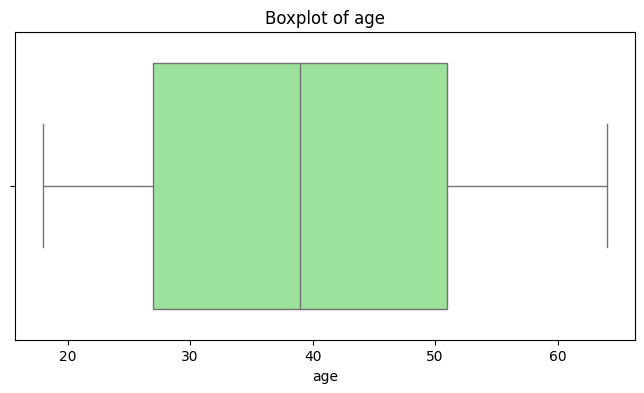

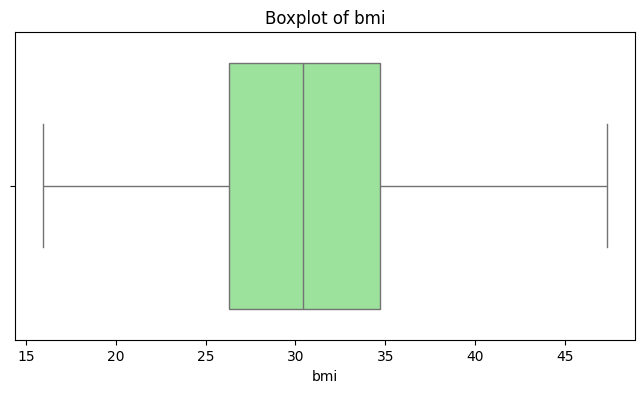

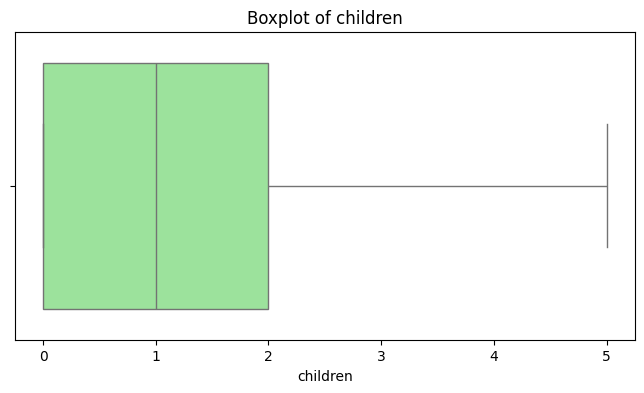

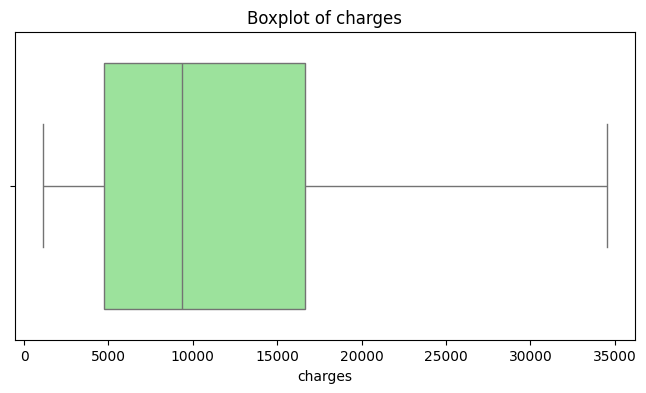

In [194]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()

In [195]:
print(df.skew(numeric_only=True))

age         0.054781
bmi         0.232892
children    0.937421
charges     1.084697
dtype: float64


In [196]:
from sklearn.preprocessing import PowerTransformer
pt_target = PowerTransformer(method='yeo-johnson')
df['charges'] = pt_target.fit_transform(df[['charges']])

pt_children = PowerTransformer(method='yeo-johnson')
df['children'] = pt_children.fit_transform(df[['children']])

In [197]:
print(df.skew(numeric_only=True))

age         0.054781
bmi         0.232892
children    0.104612
charges    -0.028673
dtype: float64


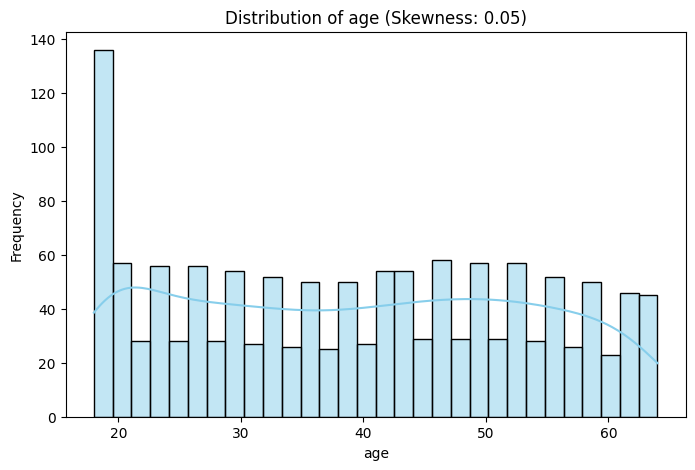

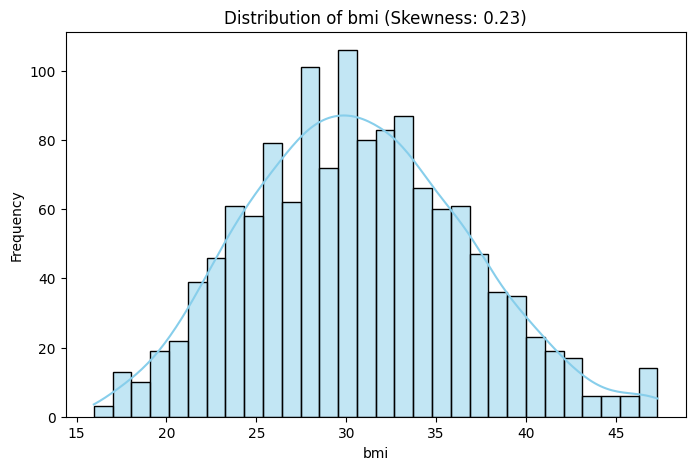

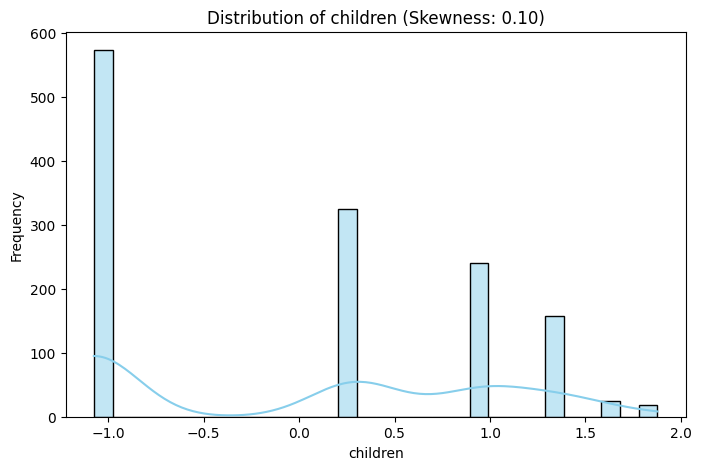

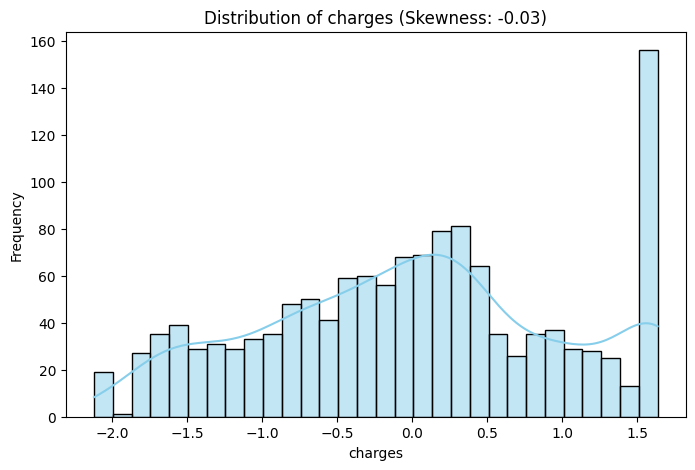

In [198]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

for col in num_cols:
    plt.figure(figsize=(8,5))
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col} (Skewness: {df[col].skew():.2f})')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

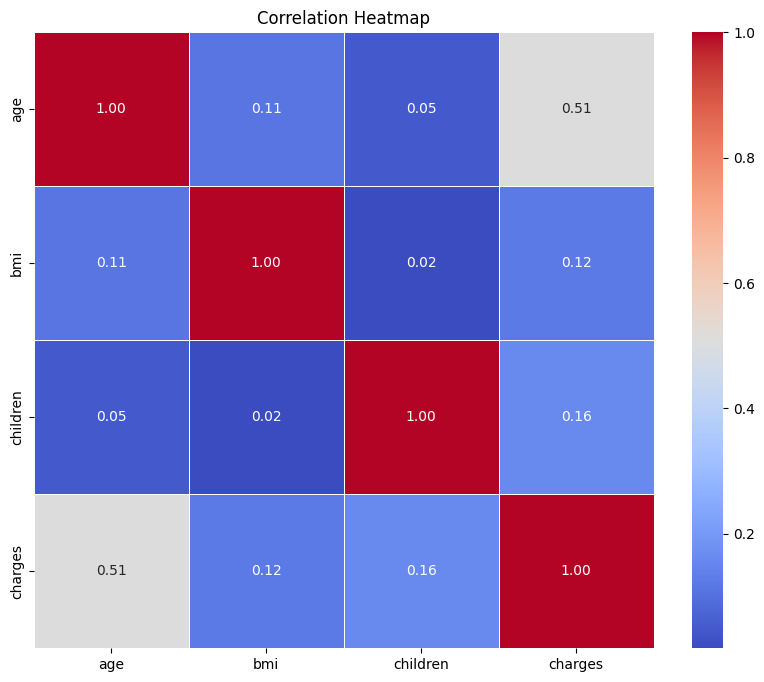

In [199]:
corr_matrix = df[num_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [200]:
X = pd.get_dummies(df[categorical_cols + numerical_cols], drop_first=True)
y = df['charges']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Save scaler & columns
pickle.dump(scaler, open("insurance_scaler.pkl", "wb"))
pickle.dump(X.columns.tolist(), open("insurance_columns.pkl", "wb"))

# Initialize models
models = {
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBRegressor": XGBRegressor(random_state=42, objective='reg:squarederror')
}

# Train, evaluate, and save
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    results[name] = {"R2": r2, "MSE": mse, "RMSE": rmse}
    
    # Save model
    pickle.dump(model, open(f"insurance_{name}.pkl", "wb"))

# Display results
results_df = pd.DataFrame(results).T
results_df["MSE"] = results_df["MSE"].apply(lambda x: round(x, 2))
results_df["RMSE"] = results_df["RMSE"].apply(lambda x: round(x, 2))
results_df["R2"] = results_df["R2"].apply(lambda x: round(x, 3))
print("=== MODEL PERFORMANCE ===")
print(results_df)

=== MODEL PERFORMANCE ===
                     R2   MSE  RMSE
GradientBoosting  0.866  0.14  0.38
RandomForest      0.828  0.19  0.43
XGBRegressor      0.780  0.24  0.49


In [201]:
df.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,-1.075608,yes,southwest,0.719687
1,18,male,33.770,0.299157,no,southeast,-1.731503
2,28,male,33.000,1.367136,no,southeast,-0.794617
3,33,male,22.705,-1.075608,no,northwest,1.049279
4,32,male,28.880,-1.075608,no,northwest,-0.940272
